### 텍스트와 시퀀스를 위한 딥러닝
이번 Post에서는 RNN을 활용하여 Sequence Dataset, Text에 대한 Model을 생성하고 알아본다.    

이에 관하여 알아두면 좋은 Post는 아래 링크를 참조하자.  
1. <a href="https://wjddyd66.github.io/dl/%EC%9E%90%EC%97%B0%EC%96%B4%EC%99%80-%EB%8B%A8%EC%96%B4%EC%9D%98-%EB%B6%84%EC%82%B0-%ED%91%9C%ED%98%84//">자연어와 단어의 분산 표현</a>
2. <a href="https://wjddyd66.github.io/dl/word2vec/">word2vec</a>
3. <a href="https://wjddyd66.github.io/dl/Fast-word2vec/">Fast word2vec</a>
4. <a href="https://wjddyd66.github.io/dl/RNN/">RNN</a>
5. <a href="https://wjddyd66.github.io/dl/LSTM/">LSTM</a>
6. <a href="https://wjddyd66.github.io/dl/seq2seq/">seq2seq</a>
7. <a href="https://wjddyd66.github.io/dl/Attention/">Attention</a>

<br>

처음 Post에서도 언급하였듯이 자세한 수식이나 원리에 대해서는 미리 Post한 곳을 참조하고 Keras Category에서는 최대한 Keras 사용법에 집중한다.

<br><br>
#### 필요한 라이브러리 Import

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers
from keras.layers import Flatten, Dense, Embedding, SimpleRNN, LSTM
from keras.datasets import imdb
from keras import preprocessing
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.optimizers import RMSprop

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

### 텍스트 데이터 다루기
Input으로 들어오는 Data가 만약 Text일 경우 어떻게 처리해야 하는지에 대한 Keras의 방향이다.  
먼저 이전 Post들 특히 <a href="https://wjddyd66.github.io/categories/#dl">DL Category</a>중에서도 위에서 언급한 RNN에 관련된 Post에서도 언급하였지만 Text를 Network에 넣기 위한 Data Format은 크게 2가지로 나뉜다.
1. One-Hot-Encoding
2. Embedding

대부분은 Embedding으로서 Text Data의 Format을 변화시키지만 One-Hot-Encoding으로도 많이 표현됨으로 2가지의 모든 경우에 대해서 알아보자.  

**One-Hot-Encoding**  
Text Data를 One-Hot-Encoding 형식으로 만드는 방법이다.  
Keras에서는 **원본 텍스트 데이터를 단어 또는 문자 수준의 One-Hot-Encoding으로 변환해주는 Tokenizer라는 유틸리티가 존재합니다.**  
신경써야하는 전처리 과정인 특수 문자를 제거하거나 빈도가 높은 N개의 단어만 선택하는 등 여러가지 중요한 기능들이 미리 존재합니다.

In [2]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(samples)

sequences = tokenizer.texts_to_sequences(samples)
one_hot_results = tokenizer.texts_to_matrix(samples)

word_index = tokenizer.word_index
word_docs = tokenizer.word_counts
for index, docs in enumerate([word_index,word_docs]):
    print(index,docs)

0 {'the': 1, 'cat': 2, 'sat': 3, 'on': 4, 'mat': 5, 'dog': 6, 'ate': 7, 'my': 8, 'homework': 9}
1 OrderedDict([('the', 3), ('cat', 1), ('sat', 1), ('on', 1), ('mat', 1), ('dog', 1), ('ate', 1), ('my', 1), ('homework', 1)])


**단어 임베딩**  
One-Hot-Encoding의 단점으로서 너무 Sparse하고 Vector의 차원이 높아서 Computing 연산시간이 오래 걸린다.  
따라서 해결방법으로서 **단어 임베딩**으로서 단어를 표현한다.  
임베딩에 관해서 생소하거나 자세한 내용이 알고 싶은 분들은 위의 Post에서 1. 자연어와 단어 분산 표현 ~ 3. Fast word2vec을 참조하면 된다.  

Keras에서는 이러한 Embedding 층을 쉽게 구성할수 있게 Embedding이라는 유틸리티를 제공한다.  
<br>

**IMDB 데이터 로드하기**  
먼저 Embedding에 사용할 Dataset을 구성하는 것 이다.  
<a href="https://wjddyd66.github.io/keras/Keras(2)/">신경망 시작하기</a>에서 언급한 imdb 데이터셋을 사용한다.  
**중요한 점은 Embedding을 하기 위하여 Input의 Size를 제한시켜야 한다. preprocessing을 통하여 최대 Input Size를 20차원으로서 제한하였다.**

In [3]:
max_features = 10000
maxlen = 20

(x_train,y_train),(x_test,y_test) = imdb.load_data(num_words=max_features)
x_train = preprocessing.sequence.pad_sequences(x_train,maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test,maxlen=maxlen)

print(x_train)
print()
print(x_test)
print(len(x_train[0]))

[[  65   16   38 ...   19  178   32]
 [  23    4 1690 ...   16  145   95]
 [1352   13  191 ...    7  129  113]
 ...
 [  11 1818 7561 ...    4 3586    2]
 [  92  401  728 ...   12    9   23]
 [ 764   40    4 ...  204  131    9]]

[[ 286  170    8 ...   14    6  717]
 [  10   10  472 ...  125    4 3077]
 [  34    2   45 ...    9   57  975]
 ...
 [ 226   20  272 ...   21  846 5518]
 [  55  117  212 ... 2302    7  470]
 [  19   14   20 ...   34 2005 2643]]
20


**imdb 데이터에 Embedding 층과 분류기 사용**  
실질적인 Train Data를 통하여 Train시키고 결과를 확인하기 위하여 Embedding 층과 분류기를 사용한다.  
자세히 살펴보기 이전에 먼저 CBOW의 Model구조를 살펴보고 실제 Code에서 어떻게 Embedding구조에 적용하였는지 알아보자.  
<img src="https://datascienceschool.net/upfiles/e62aadf1e8324d16a66288f2c83c470a.png" height="250" width="600">
위의 그림의 Embedding Layer를 구성하기 위하여 실질적인 Code는 <code>Embedding(10000,8,input_length=maxlen)</code>로서 구성하였다.  
하나하나 Paramter를 살펴보면 다음과 같다.  
- 10000: One-Hot-Encoding으로서 바꾸었을때의 Vector의 Size이다. 위에서 num_words를 10000로서 정의하였기 때문에 같은 값으로서 맞춰주었다.
- 8: 10000개의 Vector로서 이루워진 One-Hot-Encoding을 몇 차원의 Embedding으로서 표현할 것인지에 대한 Feature의 개수이다. 예를들어 12라는 단어라 King이라면 Embedding을 통하여 [남자=0.9, 권위=0.5, ...]등의 8차원의 크기의 Vector로서 맞춰준다.
- input_length: Input으로 들어오는 x의 차원 크기이다. 위에서 preprocessing을 통하여 Data의 차원을 20차원이하로 줄였다. 따라서 x의 차원은 20차원이고 최종적으로는 20 * 8 * batch_size의 Output형태로 출력되게 된다.

위의 과정으로 나온 Output을 Sigmoid를 통하여 Target Data의 0~1사이의 값으로서 바꾸고 Training을 진행하였다.

**참고 사항(GloVe)**  
GloVe(Global Vectors for Word Representation)은 미리 Training된 Embeding이다. 
수백만 개의 영어 Word에 대해서 미리 Training되어있어 앞으로의 Embeding 계층은 모두 GloVe를 통하여 쉽게 구축하고 결과를 확인한다.  
<a href="https://nlp.stanford.edu/projects/glove/">GloVe 홈페이지</a>

In [4]:
model = Sequential()
model.add(Embedding(10000,8,input_length=maxlen))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
model.summary()

history = model.fit(x_train,y_train,epochs=10,batch_size=32,validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 40us/step - loss: 0.6580 - acc: 0.6444 - val_loss: 0.5967 - val_acc: 0.7060
Epoch 2/10
20000/20000 [==============================] - 1s 35us/step - loss: 0.5248 - acc: 0.7584

### Embedding 활용하여 Network구축하기
위에서는 간략한 Data에 대해서 ANN Network를 구축하고 결과를 확인하였다.  
실제 Dataset을 다운받고 실제로 ANN Network를 구축하여 어떻게 결과를 출력하는지 알아보자.  
즉 원본 .txt File로부터 어떻게 Data Preprocessing하고 Embedding을 구축하는지에 대하여 실습한다.  
먼저 <a href="https://mng.bz/OtIo">원본 IMDB 데이터</a>를 다운로드 받고 Directory에 지정하자.  
받은 Data의 구조는 test, train Directory로서 구성되어 있고 각각의 Dataset은 neg, pos로서 분류되어있다.  
아래 과정은 neg, pos에 대하여 Dataset을 구축하는 단계이다.  
실제 Text에 대하여 pos와 neg에 따라서 Label을 붙이는 단계이다.

In [5]:
imdb_dir = './Dataset/aclImdb/'
train_dir = os.path.join(imdb_dir,'train/')

labels = []
texts = []

for label_type in ['neg','pos']:
    dir_name = os.path.join(train_dir,label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name,fname),encoding='utf8')
            texts.append(f.read())
            f.close()
                
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

**데이터 토큰화**  
위에서 실제 Text File에 대하여 Data를 구축하였다.  
이러한 Data를 Input으로 넣기위하여 토큰화를 하는 과정이다.  
먼저 Embedding을 구하기 위하여 Data를 One-Hot-Encoding을 Tokenizer를 통하여 구축하는 단계이다.

In [6]:
maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index

data = pad_sequences(sequences,maxlen=maxlen)
labels = np.asarray(labels)

print('데이터 텐서의 크기: ',data.shape)
print('레이블 텐서의 크기: ',labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples+validation_samples]
y_val = labels[training_samples:training_samples+validation_samples]

데이터 텐서의 크기:  (25000, 100)
레이블 텐서의 크기:  (25000,)


**GloVE 단어 임베딩**  
Embedding Layer를 구축하는 방법에 따라 크게 2가지로 정의하였다.  
실질적으로 Embedding Layer를 Training하여 구축하는 방법과 기존에 정의되어있는 Embeding Layer를 가져와서 사용하는 것 이다.  
현재 Training Dataset이 적기 때문에 Model 성능의 향상때문에 GloVE라는 Embedding Layer를 가져다가 사용한다.  
**중요한 점은 GloVE 의 Vocab은 100차원 이므로 위에서 Data의 maxlen을 100차원으로서 제한하였다.**  
<a href="https://nlp.stanford.edu/projects/glove/">GloVe 홈페이지</a>에서 glove.6B.zip 을 Download받을 수 있다. 압축된 .zip File의 크기가 822MB여서 Github에는 정식으로 올리지 못하고 링크를 참조하여 받아서 실습을 진행하여야 한다.  
File 구조를 살펴보면 다음과 같다.  
```code
the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062
```

각 단어에 대하여 100차원으로 Embedding된 행렬로서 표현한다.  
아래 단계는 이러한 단어에 대한 Embedding된 행렬을 가져오는 작업이다.

In [7]:
globe_dir = './Dataset/'

embeddings_index = {}
f = open(os.path.join(globe_dir,'glove.6B.100d.txt'),encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_index[word] = coefs
    
f.close()

print('%s개의 단어 백터를 찾았습니다.'% len(embeddings_index))

400000개의 단어 백터를 찾았습니다.


**Embedding 행렬 만들기**  
실질적인 Keras의 Embedding 행렬로 만드는 과정이다.  
행렬의 크기는 (max_words, embedding_dim)이여야 한다.  
또한 주의해야 하는 점은 현재 Dataset의 구축 할 때 max_words = 10000로서 표현하였다.  
현재 GloVE는 400000개의 단어 Vector를 포함하므로 10000개의 Vector로서 줄여야 한다.  
Code의 결과로서 각각의 변수는 다음과 같은 결과를 가진다.  
최종적으로 구하고자 하는 Embedding Matrix를 확인하게 되면 (max_words(=10000), embedding_dim(=100))차원의 Vector로서 표현되고 각각의 요소는 Training된 weights를 가지는 것을 확인할 수 있다.

In [8]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words,embedding_dim))

for word,i in word_index.items():
    if i < max_words:
        embeddinng_vector = embeddings_index.get(word)
        if embeddinng_vector is not None:
            embedding_matrix[i] = embeddinng_vector
            
print(embedding_matrix.shape)
print(embedding_matrix[1])

(10000, 100)
[-0.038194   -0.24487001  0.72812003 -0.39961001  0.083172    0.043953
 -0.39140999  0.3344     -0.57545     0.087459    0.28786999 -0.06731
  0.30906001 -0.26383999 -0.13231    -0.20757     0.33395001 -0.33848
 -0.31742999 -0.48335999  0.1464     -0.37303999  0.34577     0.052041
  0.44946    -0.46970999  0.02628    -0.54154998 -0.15518001 -0.14106999
 -0.039722    0.28277001  0.14393     0.23464    -0.31020999  0.086173
  0.20397     0.52623999  0.17163999 -0.082378   -0.71787    -0.41531
  0.20334999 -0.12763     0.41367     0.55186999  0.57907999 -0.33476999
 -0.36559001 -0.54856998 -0.062892    0.26583999  0.30204999  0.99774998
 -0.80480999 -3.0243001   0.01254    -0.36941999  2.21670008  0.72201002
 -0.24978     0.92136002  0.034514    0.46744999  1.10790002 -0.19358
 -0.074575    0.23353    -0.052062   -0.22044     0.057162   -0.15806
 -0.30798    -0.41624999  0.37972     0.15006    -0.53211999 -0.20550001
 -1.25259995  0.071624    0.70564997  0.49744001 -0.4206300

**Model 정의하기**  
이전에 간단한 ANN과 같은 Model구조를 가집니다.  
중요한점은 Embedding Layer는 GloVe를 사용하므로 Training되면 안됨으로 Model의 Weights를 지정하고 Training 불가능하게 정의한다.

In [9]:
model = Sequential()
model.add(Embedding(max_words,embedding_dim,input_length=maxlen))
model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable=False

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


**Model Training**

In [10]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
history = model.fit(x_train,y_train,epochs=10,batch_size=32,validation_data=(x_val,y_val))
model.save_weights('./Model/pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 0s 2ms/step - loss: 1.5012 - acc: 0.5000 - val_loss: 0.7402 - val_acc: 0.5030
Epoch 2/10
200/200 [==============================] - 0s 1ms/step - loss: 0.5137 - acc: 0.7800 - val_loss: 0.9632 - val_acc: 0.5022
Epoch 3/10
200/200 [==============================] - 0s 1ms/step - loss: 0.4416 - acc: 0.7700 - val_loss: 0.8037 - val_acc: 0.5064
Epoch 4/10
200/200 [==============================] - 0s 1ms/step - loss: 0.3308 - acc: 0.9100 - val_loss: 0.9699 - val_acc: 0.5032
Epoch 5/10
200/200 [==============================] - 0s 1ms/step - loss: 0.2778 - acc: 0.9000 - val_loss: 0.7819 - val_acc: 0.5276
Epoch 6/10
200/200 [==============================] - 0s 1ms/step - loss: 0.2176 - acc: 0.9650 - val_loss: 1.0425 - val_acc: 0.4998
Epoch 7/10
200/200 [==============================] - 0s 1ms/step - loss: 0.1741 - acc: 0.9750 - val_loss: 0.7393 - val_acc: 0.5624
Epoch 8/10
200/200 [========

**결과 시각화하기**  
결과를 확인하게 되면 매우 빨리 Overfitting이 시작되고 정확도가 50%인것을 확인 할 수 있다.  
Training Datset이 200개뿐이여서 이러한 결과를 보이게 된다.

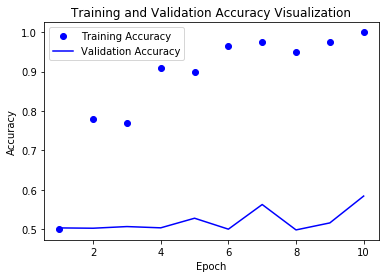

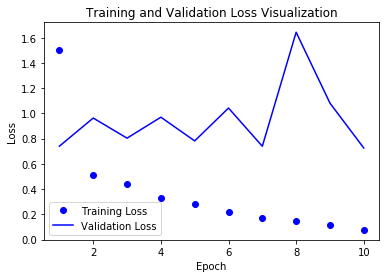

In [11]:
history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epoch = range(1,len(loss)+1)

plt.plot(epoch,acc,'bo',label='Training Accuracy')
plt.plot(epoch,val_acc,'b',label='Validation Accuracy')
plt.title('Training and Validation Accuracy Visualization')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

plt.plot(epoch,loss,'bo',label='Training Loss')
plt.plot(epoch,val_loss,'b',label='Validation Loss')
plt.title('Training and Validation Loss Visualization')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

**GloVe 사용 X**  
Embedding Layer를 GloVe가 아닌 Training 하여 직접 결과를 확인한다.  
Loss는 줄었으나 여전히 Accuraccy가 매우 낮은 것을 확인할 수 있다.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 0s 2ms/step - loss: 0.6981 - acc: 0.4700 - val_loss: 0.6946 - val_acc: 0.5040
Epoch 2/10
200/200 [==============================] - 0s 1ms/s

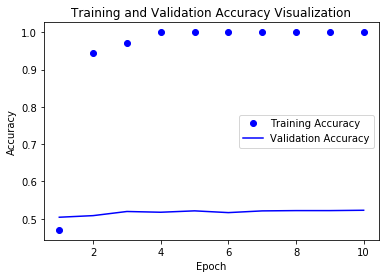

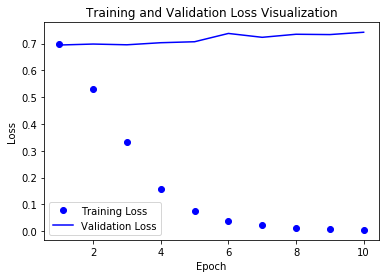

In [12]:
model = Sequential()
model.add(Embedding(max_words,embedding_dim,input_length=maxlen))
model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
history = model.fit(x_train,y_train,epochs=10,batch_size=32,validation_data=(x_val,y_val))

history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epoch = range(1,len(loss)+1)

plt.plot(epoch,acc,'bo',label='Training Accuracy')
plt.plot(epoch,val_acc,'b',label='Validation Accuracy')
plt.title('Training and Validation Accuracy Visualization')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

plt.plot(epoch,loss,'bo',label='Training Loss')
plt.plot(epoch,val_loss,'b',label='Validation Loss')
plt.title('Training and Validation Loss Visualization')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

**Test Datset으로 Model결과 확인**  
Test Dataset으로 Model의 Accuracy를 확인한다.  
결과적으로 Test Dataset으로도 50%의 Accuracy밖에 안되는 것을 확인할 수 있다.

In [13]:
imdb_dir = './Dataset/aclImdb/'
test_dir = os.path.join(imdb_dir,'test/')

labels = []
texts = []

for label_type in ['neg','pos']:
    dir_name = os.path.join(test_dir,label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name,fname),encoding='utf8')
            texts.append(f.read())
            f.close()
                
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences,maxlen=maxlen)
y_test = np.asarray(labels)

model.load_weights('./Model/pre_trained_glove_model.h5')
model.evaluate(x_test,y_test)

25000/25000 [==============================] - 0s 17us/step


[0.7379635489845275, 0.5704799890518188]

### RNN
RNN의 사전 지식이 부족하시면 <a href="https://wjddyd66.github.io/dl/RNN/">4. RNN</a> 을 참조하시면 많은 도움이 됩니다.  
Tensor 1.x와 Pytorch, Python에서 어떻게 돌아가는지 확인하였으므로 Keras를 통해서는 어떻게 Network를 구축하는지 알아보자.  

**데이터 전처리**  
RNN Network의 Input과 Output의 Dataset을 먼저 구축한다.  
Dataset은 위에서도 계속적으로 사용한 IMDB 데이터를 사용하여 구축한다.

In [14]:
max_features = 10000
maxlen = 500
batch_size = 32

print('데이터 로깅...')
(x_train, y_train),(x_test,y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), '훈련 시퀀스')
print(len(x_test),'테스트 시퀀스')

x_train = pad_sequences(x_train,maxlen=maxlen)
x_test = pad_sequences(x_test,maxlen=maxlen)

print('input_train 크기', x_train.shape)
print('input_test 크기', x_test.shape)

데이터 로깅...
25000 훈련 시퀀스
25000 테스트 시퀀스
input_train 크기 (25000, 500)
input_test 크기 (25000, 500)


**Model 구축 및 Train**  
**Keras에서 RNN을 구축하는 유틸리티를 제공한다.**  
먼저 Keras에서 제공하는 SimpleRNN을 살펴보면 다음과 같다.  
<code>keras.layers.SimpleRNN(units, activation='tanh', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0, return_sequences=False, return_state=False, go_backwards=False, stateful=False, unroll=False)</code>

각각의 Argument는 너무 많아서 <a href="https://keras.io/layers/recurrent/">Keras 정식 홈페이지</a>를 참조하자.  
기본적으로 사용하기 주로 사용하는 Argument를 살펴보면 다음과 같다.  
- units: OutputSpace의 Dimension을 정의한다.
- activation: tanh를 사용한다. tanh나 relu를 사용하지만 Keras는 tanh를 Default로서 사용한다.

나머지 Argument는 이름그대로 사용하는 그대로 나와있어서 이해하는데 어려움이 없을 것 같다.  



In [15]:
model = Sequential()
model.add(Embedding(max_features,32))
model.add(SimpleRNN(32))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])

history = model.fit(x_train,y_train,epochs=10,batch_size=128,validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 11s 552us/step - loss: 0.5858 - acc: 0.6799 - val_loss: 0.4576 - val_acc: 0.7916
Epoch 2/10
20000/20000 [==============================] - 11s 543us/step - loss: 0.3726 - acc: 0.8483 - val_loss: 0.3386 - val_acc: 0.8660
Epoch 3/10
20000/20000 [==============================] - 11s 558us/step - loss: 0.2881 - acc: 0.8878 - val_loss: 0.4305 - val_acc: 0.7990
Epoch 4/10
20000/20000 [==============================] - 11s 567us/step - loss: 0.2368 - acc: 0.9097 - val_loss: 0.3627 - val_acc: 0.8732
Epoch 5/10
20000/20000 [==============================] - 11s 563us/step - loss: 0.1883 - acc: 0.9298 - val_loss: 0.3749 - val_acc: 0.8620
Epoch 6/10
20000/20000 [==============================] - 11s 572us/step - loss: 0.1474 - acc: 0.9470 - val_loss: 0.4472 - val_acc: 0.8210
Epoch 7/10
20000/20000 [==============================] - 11s 567us/step - loss: 0.1130 - acc: 0.9607 - val_loss: 0.4

**결과 시각화**  
대략적으로 80%정도의 정확도를 얻을 수 있다  
현실적으로 실제 Text처리하는데 있어서 현재 Input으로 들어오는 Data의 Vector의 차원은 500이다.  
따라서 RNN Network의 구조의 한계로서 **Long Term Dependency**가 발생할 수 없을 것 이다.

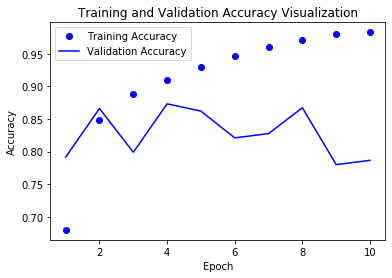

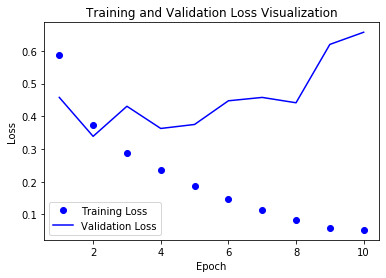

In [16]:
history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epoch = range(1,len(loss)+1)

plt.plot(epoch,acc,'bo',label='Training Accuracy')
plt.plot(epoch,val_acc,'b',label='Validation Accuracy')
plt.title('Training and Validation Accuracy Visualization')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

plt.plot(epoch,loss,'bo',label='Training Loss')
plt.plot(epoch,val_loss,'b',label='Validation Loss')
plt.title('Training and Validation Loss Visualization')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### LSTM
LSTM의 사전 지식이 부족하시면 <a href="https://wjddyd66.github.io/dl/LSTM/">5. LSTM</a> 을 참조하시면 많은 도움이 됩니다. 
위의 링크와 위의 예제에서도 살펴보았듯이 RNN을 사용하게 되는 경우 Network의 구조상 Input의 Vector의 Dimension이 커질수록 **Long Term Dependency가 발생하게 되어 Vanishing Gradient Problem**이 발생(Exploding Gradients는 발생 X)하게 된다.  
이러한 문제를 해결하기 좋은 대표적인 Network는 LSTM과 GRU이다.  
그 중 Keras에서 지원하는 LSTM에 대해서 알아보자.  

**Model 구축 및 Train**  
**Keras에서 LSTM을 구축하는 유틸리티를 제공한다.**  
먼저 Keras에서 제공하는 SimpleLSTM을 살펴보면 다음과 같다.  
<code>keras.layers.LSTM(units, activation='tanh', recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0, implementation=2, return_sequences=False, return_state=False, go_backwards=False, stateful=False, unroll=False)</code>

각각의 Argument는 너무 많아서 <a href="https://keras.io/layers/recurrent/">Keras 정식 홈페이지</a>를 참조하자.  
기본적으로 사용하기 주로 사용하는 Argument를 살펴보면 다음과 같다.  
- units: OutputSpace의 Dimension을 정의한다.
- activation: tanh를 사용한다. tanh나 relu를 사용하지만 Keras는 tanh를 Default로서 사용한다.

나머지 Argument는 이름그대로 사용하는 그대로 나와있어서 이해하는데 어려움이 없을 것 같다.

In [17]:
model = Sequential()
model.add(Embedding(max_features,32))
model.add(LSTM(32))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])

history = model.fit(x_train,y_train,epochs=10,batch_size=128,validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 28s 1ms/step - loss: 0.5017 - acc: 0.7675 - val_loss: 0.3245 - val_acc: 0.8690
Epoch 2/10
20000/20000 [==============================] - 28s 1ms/step - loss: 0.2970 - acc: 0.8848 - val_loss: 0.3846 - val_acc: 0.8542
Epoch 3/10
20000/20000 [==============================] - 28s 1ms/step - loss: 0.2314 - acc: 0.9136 - val_loss: 0.2821 - val_acc: 0.8914
Epoch 4/10
20000/20000 [==============================] - 30s 1ms/step - loss: 0.2049 - acc: 0.9244 - val_loss: 0.2839 - val_acc: 0.8856
Epoch 5/10
20000/20000 [==============================] - 28s 1ms/step - loss: 0.1807 - acc: 0.9341 - val_loss: 0.5582 - val_acc: 0.8210
Epoch 6/10
20000/20000 [==============================] - 28s 1ms/step - loss: 0.1596 - acc: 0.9431 - val_loss: 0.3445 - val_acc: 0.8748
Epoch 7/10
20000/20000 [==============================] - 28s 1ms/step - loss: 0.1495 - acc: 0.9457 - val_loss: 0.3103 - val_acc:

**결과 시각화**  
대략적으로 85%정도의 정확도를 얻을 수 있다.  
LSTM또한 만족스럽지 못한 결과를 얻었다.  
이전 <a href="https://wjddyd66.github.io/dl/LSTM/#%EA%B0%9C%EC%84%A0%EB%90%9C-time-lstm">LSTM</a>에서도 언급하였듯이 LSTM을 개선하기 위한 방법이 존재한다.  
대표적인 예로 Dropout, 양방향 LSTM, Attention Network구조 등이 존재하게 된다.

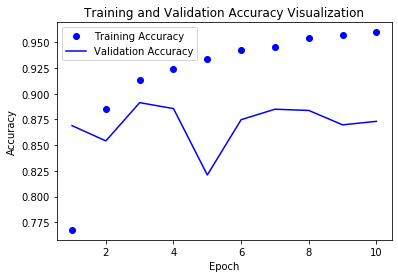

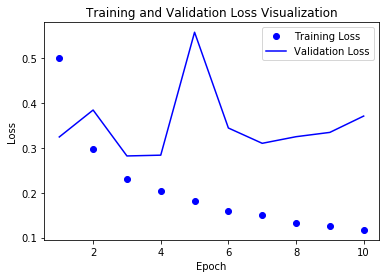

In [18]:
history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epoch = range(1,len(loss)+1)

plt.plot(epoch,acc,'bo',label='Training Accuracy')
plt.plot(epoch,val_acc,'b',label='Validation Accuracy')
plt.title('Training and Validation Accuracy Visualization')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

plt.plot(epoch,loss,'bo',label='Training Loss')
plt.plot(epoch,val_loss,'b',label='Validation Loss')
plt.title('Training and Validation Loss Visualization')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### RNN의 고급 사용법
먼저 위의 결과를 다시 상기시키고 넘어가자.  
**RNN은 Network의 구조상 Long Term Dependecy로 인하여 Model의 성능이 좋지 못하였다.**  
**RNN의 Long Term Dependency를 해결하기 위하여 LSTM을 사용하였으나 Model의 성능은 좋지 못하였다.**  
따라서 LSTM에서 좀 더 Model의 성능을 높이기 위하여 다음과 같은 방법을 적용한다.  
1) 순환 드롭아웃(recurrenet dropout): 순환 층에서 과대적합을 방지하기 위해 케라스에 내장되어 있는 드롭아웃  

2) 스태킹 순환 층(stacking recurrnet layer): <a href="https://machinelearningmastery.com/stacked-long-short-term-memory-networks/">machinelearningmastery</a>에서는 Stacking recurrnet Layer를 다음과 같이 설명하였다.  
>Stacked LSTMs or Deep LSTMs were introduced by Graves, et al. in their application of LSTMs to speech recognition, beating a benchmark on a challenging standard problem. RNNs are inherently deep in time, since their hidden state is a function of all previous hidden states. The question that inspired this paper was whether RNNs could also benefit from depth in space; that is from stacking multiple recurrent hidden layers on top of each other, just as feedforward layers are stacked in conventional deep networks.

위의 설명을 조금 쉽게 설명하면 개인적으로는 **RNN이라는 Network자체는 연속적인 데이터 중에서도 특정 Domain을 기준으로 분포되어있는 Data에 특화되어있는 Data를 해석하기 위한 Network라고 생각한다.**  
지금까지 해온 예로서 설명해보면 Text Data를 Input으로 넣었다.  
여기에서 Embedding의 경우에는 특정 단어를 기준으로 Window안에 있는 단어와의 상관관계를 통하여 Embedding 행렬로서 표현(Dog = [0.001, 0,02, ...])하였다.  
좀 더 자세히 알아보면 먼저 CBOW Embedding을 살펴보면 다음과 같다.  
<img src="https://files.slack.com/files-pri/T25783BPY-F6P9HGPGS/sliding_window.png?pub_secret=2f5ff24df3" height="250" width="600"><br>
즉, 주변 Word로 인하여 Target Word를 특정 Feature의 값으로서 표현한 것이기 때문에 단어의 순서에 대한 Domain에 결과라고 표현할 수 있다.  
따라서 RNN에 넣는 Data를 Embedding으로서 전처리하여 표현할 수 있다.  
**하지만 하나의 LSTM Model로서 구현하게 되면 하나의 특정 Domain에 대한 Model의 예측 결과를 뽑아낼 수 밖에 없다.**  
따라서 **스태킹 순환 층이란 여러개의 LSTM Model로서 구현하게 되어 하나의 특정 Domain이 아닌 여러 Domain에 대한 Model의 예측 결과를 뽑아내는 것 이다.** 그림으로서 표현하게 되면 다음과 같다.  
<img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/07/architecture_stacked_lstm.png"/><br>
사진 참조: <a href="https://machinelearningmastery.com/stacked-long-short-term-memory-networks/">machinelearningmastery</a><br>
중요한 점은 LSTM은 특정 Domain에 대한 Output을 뽑아내는 Model이므로 맨 위의 LSTM의 output은 하나의 Sequence로서 나와야 한다는 것 이다.  

3) 양방향 순환 층(bidirectional recurrent layer): LSTM으로서 Long Term Dependency 어느 정도 해결하였어도 전부 다 해결된 것이 아니다. 따라서 하나의 Sequence를 원본 그대로 넣고, 순서를 거꾸로 뒤집어서 넣음으로 인하여 Model의 성능을 향상시킨다.  
예를들어 영어 Text인 경우 문장의 5형식을 생각해보면 S,V 가 맨 앞에 오게 된다.  
문장의 요소중에 가장 중요하다고 할 수 있는 S,V가 앞에 오므로 Google을 Model을 Training할 때 문장의 순서를 뒤집어서 넣는 것으로 인하여 Model의 성능을 향상시켰다고 한다.  


#### 기온 예측 문제
이번 기온 예측 문제는 날씨의 데이터에 관해서 예측하는 Model을 만드는 것을 목적으로 한다.  
Data는 특정 시간에 따라서 기온, 기압, 습도, 풍향 등 14개의 관측치가 10분마다 기록되어 있다.  
따라서 위에서 설명한 LSTM의 Model향상을 위한 3가지 기법을 적용하면서 Time Domain에 따른 연속적인 날씨 Data를 활용하여 예측하는 Model을 만드는 것을 목적으로 한다.  

**날씨 데이터셋 조사하기**  
먼저 <a href="https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip">Amazon의 날씨 데이터</a>를 다운받는다.  
다운받은 Data를 확인하게 되면 Time에 따른 각각의 요소들의 값을 확인할 수 있다.

In [39]:
data_dir = './Dataset'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print('Header')
print(header)
print('Data')
print(lines[0])

Header
['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
Data
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30


**데이터 전처리 및 시각화**  
위에서 다운받고 확인한 데이터를 Model에 넣기위한 전처리 과정으로서 Numpy로 Data의 구조를 변형시키고 전체 기간의 온도 시각화와, 10일간의 온도 변화 시각화를 통하여 Data를 살펴본다.  

데이터셋 전체 기간의 온도를 보게 되면 일정한 주기마다 특정한 분포를 보여주는 것을 확인할 수 있다.

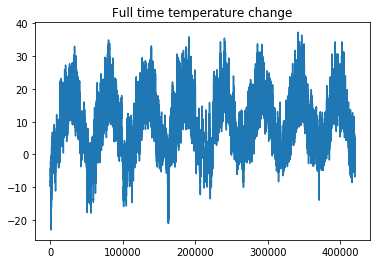

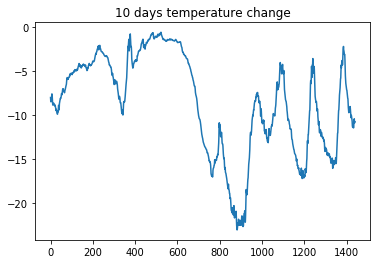

In [40]:
float_data = np.zeros((len(lines),len(header)-1))
for i,line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i,:] = values
    
temp = float_data[:,1]

plt.plot(range(len(temp)),temp)
plt.title('Full time temperature change')
plt.figure()

plt.plot(range(1440),temp[:1440])
plt.title('10 days temperature change')

plt.show()

**데이터 전처리2**  
최종적인 Model은 14가지의 Factor 중 13개의 Factor를 통하여 온도 Factor를 예측해야 하는 Model이다. 전처리 과정으로서 2가지의 제약사항을 먼저 생각해야 한다.  
1. 13개의 Factor는 값의 범위가 다르다. 따라서 Normalization을 해서 정규화 과정을 거쳐야 한다.
2. Data의 Size가 너무 크므로 Generator를 사용하여 Memory를 효율적으로 사용하여야 한다.

먼저 Normalization의 경우 다음과 같이 Z-score로서 나타낼 수 있다.

In [41]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

Data를 가져오는 Generator를 만들기 전에 우선 Generator가 무엇인지 부터 알아보자.  
Python Docs에서는 Generator를 다음과 같이 설명하였다.  
>generator
A function which returns an iterator. It looks like a normal function except that it contains yield statements for producing a series of values usable in a for-loop or that can be retrieved one at a time with the next() function. Each yield temporarily suspends processing, remembering the location execution state (including local variables and pending try-statements). When the generator resumes, it picks-up where it left-off (in contrast to functions which start fresh on every invocation).

즉, Generator는 iterator를 생성해주는 Function이다. iterator는 next() Method를 이용해 데이터에 순차적으로 접근이 가능하 Object이다.  
**Generator와 Function의 가장 큰 차이점은 yield를 사용한다는 것 이다.**  
먼저 일반적인 Function인 경우 사용이 종료되면 결과값이 호출부로 반환 후 함수 자체를 종료시킨 후 메모리 상에서 클리어 된다.  
하지만 yield를 사용할 경우 반환값을 next()를 호출한 쪽으로 전달한 뒤 **일반적인 함수처럼 종료되는 것이 아니라 그 상태로 유지하게 된다. 즉, 함수에서 사용된 local변수나 instruction pointer등과 같은 함수 내부에서 사용된 데이터들이 메모리에 그대로 유지되는 것 이다.**  

또한 이번에 Generator를 사용하게 된 이유 중 하나인 **Memory**를 효율적으로 사용할 수 있다.  
List와 비교하면 **List는 List안에 속한 모든 데이터를 메모리에 적재하기 때문에 list의 크기 만큼 차지하는 메모리 사이즈가 늘어나게 된다. 하지만 generator의 경우 데이터 값을 한꺼번에 적재하는 것이 아니라 next()메소드를 통해 차례로 값에 접근할 때 마다 메모리를 적재하는 방식이다.**  

아래 예시는 Generator의 next()로서 호출한다는 의미와 Memory사용랴을 확인할 수 있는 Code이다.  
참조: <a href="https://bluese05.tistory.com/56">ㅍㅍㅋㄷ 블로그</a>

In [42]:
import sys
# next() 예시
def example_generator(n):
    i = 0
    while i < n:
        yield i
        i += 1


for x in example_generator(5):
    print(x)

# Memory 사용 예시
print('List')
print(sys.getsizeof( [i for i in range(100) if i % 2] ))    # list
print(sys.getsizeof( [i for i in range(1000) if i % 2] ))
print('Generator')
print(sys.getsizeof( (i for i in range(100) if i % 2) ))    # generator
print(sys.getsizeof( (i for i in range(1000) if i % 2) ))

0
1
2
3
4
List
528
4272
Generator
88
88


데이터 셋을 생성하기 위한 제너레이터 함수는 (samples, targets) 튜플을 반복적으로 반환한다.  
samples는 입력 데이터로 사용할 배치이고 targets은 이에 대응되는 타깃 온도의 배열입니다.  

**Generator Argument**  
* data: 원본 Data 
* lookback: 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
* delay: 타깃으로 사용할 미래의 타임스텝
* min_index, max_index: 추출할 타임스텝의 범위를 지정하기 위한 data 배열의 인덱스. 검증 데이터와 테스트 데이터를 분리하는 데 사용합니다.
* shuffle: 샘플을 섞을지 시간 순서대로 추출할지 결정합니다. Model의 성능을 높이기 위하여 Test Data의 경우 Shuffle을 통하여 Random한 Index의 Data를 생성하지만 Validation이나 Test의 경우에는 이러한 작업을 거치지 않습니다.
* batch_size: 배치의 샘플 수
* step: 데이터를 샘플링할 타임스텝 간격. 한 시간에 하나의 데이터 포인트를 추출하기 위해 6으로 지정하겠습니다.

아래 generator()를 살펴보게 되면 batch_size만큼의 Data를 잘라오게 되고, 만약 shuffle이 True라면 Random하게 Data를 가져오게 된다. 
1. min_index ~ max_index까지의 Index중 Random하게 batch_size만큼을 rows에 저장
2. Batch_size만큼의 Data를 만들게 되는데 samples = lookback/step의 개수 만큼 과거 ~ 현재까지의 Data, targets = delay의 개수만큼 현재 ~ 미래 까지의 Data를 반환한다.


In [43]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

**데이터 전처리 3**  
최종적으로 위에서 선언한 Generator를 사용하여 Train, Validation, Test Dataset을 구축한다.  
최종적인 Dataset의 Parameter들을 생각하면 다음과 같다.  
- test data: 먼저 10일치의 Data를 전부 가져오는게 아니라 step = 6으로 선언하여 1시간마다의 Data를 가져오게 된다.  
- target data: 144 = 24*6 즉, 하루 뒤의 Data를 가져오게 된다.

최종적인 Model은 지난 10일치의 14개의 Factor를 Input으로 넣고 Train하게 되어 현재 온도가 아닌 1일 후의 온도를 측정하는 Model로서 Training이 된다.  

만약 Model을 Serving하게 된다면 현재 기준으로 10일치 전까지의 날씨 Factor를 Normalization을 통하여 Input으로 넣게 되면 내일 온도(시간은 동일 즉, 10시 10분이 기준이면 내일 10시 10분 온도)를 측정할 수 있는 것 이다.

In [44]:
lookback=1440
batch_size=128
step = 6
delay = 144

train_gen = generator(float_data,lookback=lookback,
                     delay=delay,min_index=0,
                     max_index=20000,shuffle=True,
                     step=step,batch_size=batch_size)

val_gen = generator(float_data,lookback=lookback,
                     delay=delay,min_index=20001,
                     max_index=30000,
                     step=step,batch_size=batch_size)

test_gen = generator(float_data,lookback=lookback,
                     delay=delay,min_index=30001,
                     max_index=None,
                     step=step,batch_size=batch_size)

val_steps = (30000-20001-lookback) // batch_size
test_steps = (len(float_data)-30001-lookback) // batch_size

**ANN Model Training**  
LSTM, 개선된 LSTM Model을 Training을 하기전에 간단한 ANN Model로서 결과를 확인한다.  

In [26]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(),loss='mae')

history = model.fit_generator(train_gen, steps_per_epoch=500,epochs=20,
                             validation_data=val_gen,validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 4s 8ms/step - loss: 0.3286 - val_loss: 2.8611
Epoch 2/20
500/500 [==============================] - 4s 8ms/step - loss: 0.1458 - val_loss: 3.3544
Epoch 3/20
500/500 [==============================] - 4s 8ms/step - loss: 0.1085 - val_loss: 4.7486
Epoch 4/20
500/500 [==============================] - 4s 8ms/step - loss: 0.0872 - val_loss: 6.3157
Epoch 5/20
500/500 [==============================] - 4s 8ms/step - loss: 0.0778 - val_loss: 6.0312
Epoch 6/20
500/500 [==============================] - 4s 8ms/step - loss: 0.0715 - val_loss: 5.5751
Epoch 7/20
500/500 [==============================] - 4s 8ms/step - loss: 0.0677 - val_loss: 5.6917
Epoch 8/20
500/500 [==============================] - 4s 8ms/step - loss: 0.0649 - val_loss: 5.2994
Epoch 9/20
500/500 [==============================] - 4s 8ms/step - loss: 0.0625 - val_loss: 5.4658
Epoch 10/20
500/500 [==============================] - 4s 8ms/step - loss: 0.0610 - val_loss: 5.4273

**Model 결과 시각화**  
Training Loss는 0에 가깝지만, Validation Loss는 값이 낮아지지 않는 것을 확인할 수 있다.

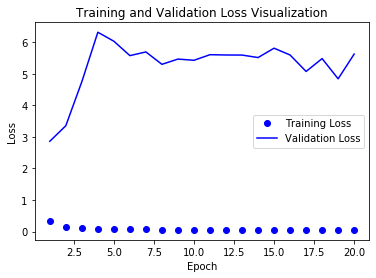

In [27]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epoch = range(1,len(loss)+1)

plt.plot(epoch,loss,'bo',label='Training Loss')
plt.plot(epoch,val_loss,'b',label='Validation Loss')
plt.title('Training and Validation Loss Visualization')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

**LSTM Model Training**  
책에서는 GRU를 통하여 Model을 구축하고 결과를 확인하였으나 다음과 같은 이유로 인하여 LSTM으로서 Model을 변경하고 결과를 확인합니다.  

**참조사항**  
<span style="color:red">현재 저의 Keras의 Version은 2.3.1입니다. 하지만 LSTM, GRU Model을 사용하는 경우 recurrnet_dropout와 dropout을 특정 값으로 지정할 시 Error가 발생하게 됩니다.(Loss가 너무 커져 NaN값으로 추정)</span>  
<a href="https://keras.io/layers/recurrent/">Keras정식 홈페이지</a>에서 GRU의 Dropout Parameter를 살펴보게 되면  
- dropout: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the inputs.
- recurrent_dropout: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the recurrent state.

하지만 작동하지 않았습니다.  
따라서 Model을 Hpyerparameter Tuning을 먼저 성공한 LSTM으로 잡고 앞으로의 실습을 진행하였습니다.  

RNN Network에서 사용하는 dropout과 recurrent_dropout에 대해서 다시 공부하고(다음 Post에정) 확인한 뒤 다시 Code에 제대로 적용시키려고 예상중 입니다.  

현재 Dataset은 Time이라는 특정 Domain에 따라서 연속적인 값으로서 표현되어 있다.  
따라서 이러한 Sequence에 강점을 보이는 RNN Network의 종류 중 하나를 선택하여서 결과를 확인한다.  
RNN의 Network의 단점을 극복한 대표적인 Network로서 LSTM과 GRU가 있다고 소개하였었다.  
이번 Network는 LSTM로서 Network를 구성하고 결과를 확인하자.

In [28]:
model = Sequential()
model.add(layers.LSTM(32,input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop',loss='mae')

history = model.fit_generator(train_gen, steps_per_epoch=500,epochs=20,
                             validation_data=val_gen,validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 39s 79ms/step - loss: 0.2206 - val_loss: 0.4943
Epoch 2/20
500/500 [==============================] - 39s 78ms/step - loss: 0.1484 - val_loss: 0.4906
Epoch 3/20
500/500 [==============================] - 39s 79ms/step - loss: 0.1148 - val_loss: 0.4806
Epoch 4/20
500/500 [==============================] - 40s 81ms/step - loss: 0.0984 - val_loss: 0.5474
Epoch 5/20
500/500 [==============================] - 39s 77ms/step - loss: 0.0872 - val_loss: 0.5672
Epoch 6/20
500/500 [==============================] - 39s 77ms/step - loss: 0.0787 - val_loss: 0.5807
Epoch 7/20
500/500 [==============================] - 38s 77ms/step - loss: 0.0734 - val_loss: 0.6164
Epoch 8/20
500/500 [==============================] - 39s 78ms/step - loss: 0.0682 - val_loss: 0.6040
Epoch 9/20
500/500 [==============================] - 39s 77ms/step - loss: 0.0655 - val_loss: 0.6090
Epoch 10/20
500/500 [==============================] - 39s 78ms/step - loss: 0.062

**Model 결과 시각화**  
Model의 Loss가 많이 개선되었지만 Overfitting이 발생하는 것을 확인할 수 있다.

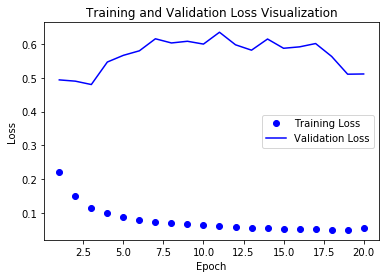

In [29]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epoch = range(1,len(loss)+1)

plt.plot(epoch,loss,'bo',label='Training Loss')
plt.plot(epoch,val_loss,'b',label='Validation Loss')
plt.title('Training and Validation Loss Visualization')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

**LSTM + Dropout**    

위에서 Network의 성능 향상을 위하여 적용시킬 기법 3가지 중에서 **1) 순환 드롭아웃(recurrenet dropout): 순환 층에서 과대적합을 방지하기 위해 케라스에 내장되어 있는 드롭아웃**을 적용한다.  
Dropout을 활용하여 Overfitting을 방지할 효과를 기대할 수 있다.  

LSTM Model에서는 Dropout에 대한 2가지 Parameter를 가지고 있다.
- dropout: 입력에 대한 드롭아웃 비율을 정하는 부동 소수값
- recurrnet_dropout: 순환 상태의 드롭아웃 비율을 정한다.

**또한 RNN Network의 종류들은 TimeStep에 상관없이 동일한 마스크를 모든 TimeStep에 적용해야지 Backpropagation에서 적절한 Loss가 전파될 것이다.**  
만약 Dropout이 다르다면 하나의 가중치를 공통으로 공유하는 RNN Network의 구조에서 Backpropagation이 잘 적용 안될 것을 예상할 수 있다.  
또한 실제로 Overfitting이 해소되었는지 확인하기 위해서 위의 GRU Model보다 Epoch의 수를 늘렸다.  

In [30]:
model = Sequential()
model.add(layers.LSTM(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))

model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 40s 80ms/step - loss: 0.2838 - val_loss: 0.2303
Epoch 2/40
500/500 [==============================] - 39s 79ms/step - loss: 0.2470 - val_loss: 0.2115
Epoch 3/40
500/500 [==============================] - 40s 80ms/step - loss: 0.2310 - val_loss: 0.1869
Epoch 4/40
500/500 [==============================] - 40s 79ms/step - loss: 0.2184 - val_loss: 0.2000
Epoch 5/40
500/500 [==============================] - 40s 79ms/step - loss: 0.2057 - val_loss: 0.2102
Epoch 6/40
500/500 [==============================] - 40s 79ms/step - loss: 0.1961 - val_loss: 0.1910
Epoch 7/40
500/500 [==============================] - 41s 81ms/step - loss: 0.1911 - val_loss: 0.2029
Epoch 8/40
500/500 [==============================] - 40s 80ms/step - loss: 0.1858 - val_loss: 0.1980
Epoch 9/40
500/500 [==============================] - 41s 81ms/step - loss: 0.1807 - val_loss: 0.2014
Epoch 10/40
500/500 [==============================] - 41s 81ms/step - loss: 0.176

**Model 결과 시각화**  
Overfitting이 어느정도 해결되었으나 결국에는 20정도를 넘어가게 되면 다시 Overfitting이 발생되는 것을 확인할 수 있다.

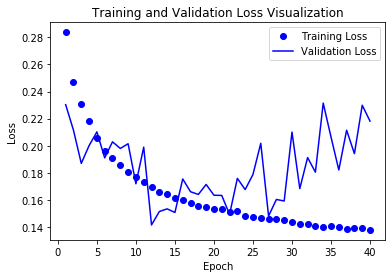

In [31]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epoch = range(1,len(loss)+1)

plt.plot(epoch,loss,'bo',label='Training Loss')
plt.plot(epoch,val_loss,'b',label='Validation Loss')
plt.title('Training and Validation Loss Visualization')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

**LSTM + Dropout + 스태킹 순환 층(stacking recurrnet layer)**  
위의 결과에서 Overfitting이 발생되지 않는 것을 확인하였으므로 Model의 성능을 향상시키기 위한 과정이다.  
위에서 스태킹 순환 층(stacking recurrnet layer)을 통하여 하나의 Domain에 대한 Model이 아닌 여러 Domain에 대한 Model을 구축하기 위하여 LSTM을 여러 층으로 쌓아서 해결한다고 설명하였다.  
이번에 구축해볼 Model은 LSTM를 2개의 층으로 구축하여 결과를 확인한다.  
**중요한 것은 LSTM와 같은 RNN Network는 특정 Domain에 대한 연속성을 가져야 하므로 <code>return_sequences = True</code>로 설정하여 1번째 LSTM는 Sequence형태로 Output을 2번째 LSTM의 Input으로 전달하여야 한다.**

In [56]:
model = Sequential()
model.add(layers.LSTM(32,
                     dropout=0.2,recurrent_dropout=0.2,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))

model.add(layers.LSTM(32, dropout=0.2,recurrent_dropout=0.2))

model.add(layers.Dense(1))
model.compile(optimizer='rmsprop',loss='mae')

history = model.fit_generator(train_gen, steps_per_epoch=500,epochs=20,
                             validation_data=val_gen,validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 121s 241ms/step - loss: 0.3018 - val_loss: 0.2177
Epoch 2/20
500/500 [==============================] - 118s 236ms/step - loss: 0.2597 - val_loss: 0.2605
Epoch 3/20
500/500 [==============================] - 116s 232ms/step - loss: 0.2387 - val_loss: 0.2739
Epoch 4/20
500/500 [==============================] - 116s 232ms/step - loss: 0.2271 - val_loss: 0.3027
Epoch 5/20
500/500 [==============================] - 114s 228ms/step - loss: 0.2116 - val_loss: 0.2650
Epoch 6/20
500/500 [==============================] - 115s 229ms/step - loss: 0.2015 - val_loss: 0.3017
Epoch 7/20
500/500 [==============================] - 118s 237ms/step - loss: 0.1939 - val_loss: 0.3621
Epoch 8/20
500/500 [==============================] - 116s 233ms/step - loss: 0.1871 - val_loss: 0.3341
Epoch 9/20
500/500 [==============================] - 119s 237ms/step - loss: 0.1810 - val_loss: 0.4428
Epoch 10/20
500/500 [==============================] - 118s 236m

**Model 결과 시각화**  
기존보다 Overfitting이 더 심해진 것을 알 수 있다. 간단한 Model로서 표현 가능한데 계속하여 더 깊게 쌓을려다 보니 생긴 문제점으로 예상된다.

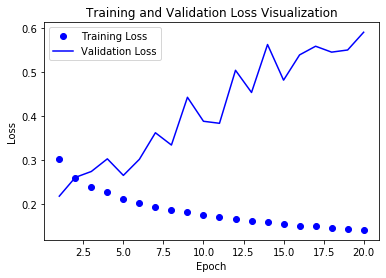

In [57]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epoch = range(1,len(loss)+1)

plt.plot(epoch,loss,'bo',label='Training Loss')
plt.plot(epoch,val_loss,'b',label='Validation Loss')
plt.title('Training and Validation Loss Visualization')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

**LSTM + Dropout + 양방향 순환 층(bidirectional recurrent layer)**  
성능이 좋지 않았던 스태킹 순환 층(Overfitting이 더 심하게 발생)을 제외하고 Keras가 지원하는 <code>layers.Bidirectional()</code>를 활용하여 양방향 순환층을 형성하고 결과를 확인한다.

In [67]:
model = Sequential()
model.add(layers.Bidirectional(
    layers.LSTM(32, dropout=0.2,recurrent_dropout=0.2,), 
    input_shape=(None, float_data.shape[-1])))

model.add(layers.Dense(1))
model.compile(optimizer='rmsprop',loss='mae')

history = model.fit_generator(train_gen, steps_per_epoch=500,epochs=20,
                             validation_data=val_gen,validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 51s 103ms/step - loss: 0.2628 - val_loss: 0.4645
Epoch 2/20
500/500 [==============================] - 54s 108ms/step - loss: 0.2256 - val_loss: 0.4957
Epoch 3/20
500/500 [==============================] - 55s 109ms/step - loss: 0.2078 - val_loss: 0.4924
Epoch 4/20
500/500 [==============================] - 52s 105ms/step - loss: 0.1968 - val_loss: 0.5142
Epoch 5/20
500/500 [==============================] - 52s 104ms/step - loss: 0.1853 - val_loss: 0.5654
Epoch 6/20
500/500 [==============================] - 52s 104ms/step - loss: 0.1783 - val_loss: 0.4712
Epoch 7/20
500/500 [==============================] - 52s 105ms/step - loss: 0.1697 - val_loss: 0.5561
Epoch 8/20
500/500 [==============================] - 52s 105ms/step - loss: 0.1642 - val_loss: 0.5305
Epoch 9/20
500/500 [==============================] - 52s 104ms/step - loss: 0.1589 - val_loss: 0.5554
Epoch 10/20
500/500 [==============================] - 51s 101ms/step - l

**Model 결과 시각화**  
결과적으로 Model의 성능이 그냥 LSTM + Dropout을 사용했을 때 보다 좀 더 안좋아진 것을 확인할 수 있다.  
왜 이런지 생각해보면 다음과 같다.  
기본적으로 RNN은 하나의 가중치를 공유함으로써 인하여 Input Data의 Vector가 길어짐에 따라 Time Step이 길어지게 되고 결국에는 Long Term Dependency가 발생하게 된다.  

이러한 해결방안으로 LSTM을 사용한다고 생각하면 Forget Gate + Input Gate로서 어느정도 해결하였다.  
**하지만 결국에는 σ(시그모이드)를 곱하게 되어서 0 ~ 1사이의 값을 가지게 되므로 계속해서 TimeStep이 길어지게 되면 Long Term Dependency가 발생하게 된다.**  
이것을 해결하기 위하여 Input Data를 거꾸로 해서 넣는 다는 것 이다.  

**하지만 중요한 것은 이러한 양방향 순환 층(bidirectional recurrnet layer)는 더 좋은 성능을 보여주는 Dataset이 있고 그렇지 않은 Dataset이 있다.**  

먼저 안 좋은 성능을 보여주는 Dataset부터 살펴보면 위의 날씨예측같은 Data이다.  
RNN Model을 마지막에 들어오는 Time Step의 Input Value가 가장 영향을 많이 미칠 수 있다.  
위의 날씨예측 같은 Data를 양방향으로 넣는다고 생각해보자.  
1900 ~ 2000년 순으로 넣어서 2000년의 Data의 영향을 더 많이 받는 Model이 2001년의 Data를 더 잘 예측할 것인가?  
2000 ~ 1900년 순으로 넣어서 1900년의 Data의 영향을 더 많이 받는 Model이 2001년의 Data를 더 잘 예측할 것인가?  
답은 간단히 생각해도 전자 일 것이다.  

그렇다면 좋은 성능을 보여주는 Dataset에 대하여 생각해보자.  
위에서도 예시를 들었지만 영어 문장을 생각해 보자.  
1 형식: 주어 + 동사  
2 형식: 주어 + 동사 + 보어  
3 형식: 주어 + 동사 + 목적어  
4 형식: 주어 + 동사 + 간접목적어 + 직접목적어  
5 형식: 주어 + 동사 + 목적어 + 목적격 보어  

이다.  
만약 Input의 Data를 거꾸로 하게 넣게 되면은 문장의 요소에서 제일 중요하다고 할 수 있는 주어와 동사에 영향을 더 많이 받는 Model을 만들 수 있다.  
이렇게 되면 Model의 성능이 향상될 것이라고 생각할 수 있다.  
Model을 시각화해보면 다음과 같다.  
<img src="https://s3.amazonaws.com/book.keras.io/img/ch6/bidirectional_rnn.png"/><br>
사진 출처: <a href="https://s3.amazonaws.com">amazon</a>

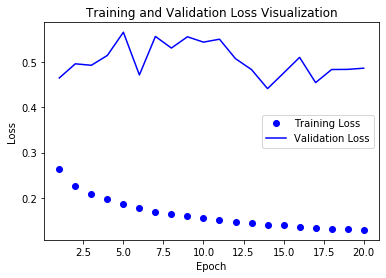

In [68]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epoch = range(1,len(loss)+1)

plt.plot(epoch,loss,'bo',label='Training Loss')
plt.plot(epoch,val_loss,'b',label='Validation Loss')
plt.title('Training and Validation Loss Visualization')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### CNN 1D를 활용하여 시퀀스 데이터 처리
CNN에서는 대부분 Image처리는 Convolution2D를 사용하게 되고, ROS와 같이 Cloud Point를 처리할 때는 Convolution3D를 사용하게 된다.  

Convolution1D를 사용하게 되면 Sparse한 Data를 Dense하게 나타낼 수 있다.  
기존의 Convolution2D를 생각하게 되면 Kernel을 w x h 로서 나타내었다.  
즉, Image의 가로 세로 범위안에 들어오는 Pixel에 대하여 Feature를 뽑겠다는 말 이다.  
**그렇다면 Convolution1D를 사용하게 되면 특정 1개의 Domain에 대한 Feature를 뽑아 낼 수 있다는 것 이다.**  

Sequence 데이터에서 RNN Network를 사용한 이유는 특정한 Time Domain에 맞춰 연속적인 Data를 잘 처리할 수 있는 Network구조이기 때문이다.  

그렇다면 Convolution1D를 사용하고 특정한 Domain을 Time Domain에 맞추게 된다면 어느정도의 결과를 얻을 수 있다.  
예를들어 보면 만약, Data의 Input이 하루 기준으로 들어오게 되고 Convolution1D의 Filter Size의 크기가 7이라면 1주일의 기준으로 월 ~ 일 까지의 Factor 들에 대하여 가중치를 부여할 수 있다.  
**따라서 RNN Network보다 효율성은 떨어지게 되어도 짧은 시간안에 결과를 도출할 수 있는 Model을 만들 수 있을 것이라 생각할 수 있다.**  

**데이터 전처리**  
먼저 imdb Dataset을 불러온다.

In [70]:
max_features = 10000
max_len = 500

print('데이터 로드...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), '훈련 시퀀스')
print(len(x_test), '테스트 시퀀스')

print('시퀀스 패딩 (samples x time)')
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)
print('x_train 크기:', x_train.shape)
print('x_test 크기:', x_test.shape)

데이터 로드...
25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (samples x time)
x_train 크기: (25000, 500)
x_test 크기: (25000, 500)


**Convolution 1D Network**  
Convolution1D를 사용하여 Network를 구성한다.  
Convolution에 관한 Keras 공식 문서는 링크를 참조하자. <a href="https://keras.io/layers/convolutional/"></a>  
중요한 점은 <code>layers.Faltten()</code>층을 없애고 <code>layers.GlobalMaxPooling1D()</code>을 통하여 나타내었다.

In [71]:
model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
___________________________________________

**결과 시각화**  
RNN Network보다 Accuracy는 떨어지게 되나, 시간은 훨씬 단축되는 것을 확인할 수 있다.  
Model의 대략적인 방향을 잡기위한 Parameter선택이나, 단어 수준의 감성 분류 작업같은 작은 Network구조에서 빠르게 결과를 확인하기 위하여 많이 사용된다.

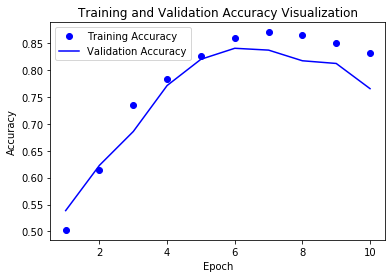

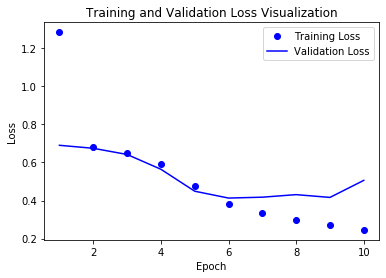

In [72]:
history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epoch = range(1,len(loss)+1)

plt.plot(epoch,acc,'bo',label='Training Accuracy')
plt.plot(epoch,val_acc,'b',label='Validation Accuracy')
plt.title('Training and Validation Accuracy Visualization')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

plt.plot(epoch,loss,'bo',label='Training Loss')
plt.plot(epoch,val_loss,'b',label='Validation Loss')
plt.title('Training and Validation Loss Visualization')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

**Convlution1D의 한계점**  
위에서도 말하였지만 특정 Domain에 대한 Filter를 씌워서 각각의 가중치를 주는 형식이기 때문에 Sequence Data에 대하여 어느정도 효과는 있을지 몰라도 성능은 보장할 수 없다고 설명하였다.  

따라서 Time Step이 매우 중요한 요소였던 날씨 데이터를 가지고 예측하는 것을 Convolution1D로서 구현하고 한계점을 확인해보자.

In [75]:
model = Sequential()
model.add(layers.Conv1D(32,5,activation='relu',input_shape=(None,float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32,5,activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32,5,activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 7s 13ms/step - loss: 0.2963 - val_loss: 0.2225
Epoch 2/20
500/500 [==============================] - 7s 13ms/step - loss: 0.2348 - val_loss: 0.1972
Epoch 3/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2062 - val_loss: 0.1484
Epoch 4/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1870 - val_loss: 0.2620
Epoch 5/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1734 - val_loss: 0.1803
Epoch 6/20
500/500 [==============================] - 7s 15ms/step - loss: 0.1613 - val_loss: 0.1643
Epoch 7/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1538 - val_loss: 0.2512
Epoch 8/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1462 - val_loss: 0.2352
Epoch 9/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1389 - val_loss: 0.2509
Epoch 10/20
500/500 [==============================] - 7s 13ms/step - loss: 0.1342 - val_lo

**결과 확인**  
예상대로 LSTM보다 성능이 떨어지는 것을 확인할 수 있다.

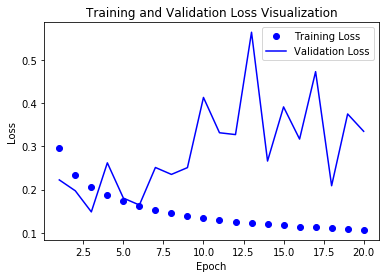

In [76]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epoch = range(1,len(loss)+1)

plt.plot(epoch,loss,'bo',label='Training Loss')
plt.plot(epoch,val_loss,'b',label='Validation Loss')
plt.title('Training and Validation Loss Visualization')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

**Convolution1D + RNN**  
기존 Convolution1D만은 사용한 Model의 성능은 좋지 않은 것을 확인하였다.  
따라서 Convolution1D의 장점을 활용하여 RNN의 전처리 과정으로 사용하여 보자.  
기본적으로 Convolution1D뿐만 아니라 Convolution을 사용하는 자체가 특정 Data의 Feature를 뽑아서 Channel의 수는 늘어나도 Data의 Size는 줄어드는 효과가 발생하게 된다.  
즉, Convolution1D는 **Sequence의 길이가 긴 Data를 Dense하게 바꾸는데 효과가 있다 라고 생각할 수 있다.**  
아래 그림은 이러한 Idea에서 온 Convolution1D + RNN의 구조이다.  
<img src="https://miro.medium.com/max/266/0*dFnGIGU0PnKLCHGD.jpg"/><br>
사진 참조: <a href="https://medium.com/@jon.froiland/convolutional-neural-networks-for-sequence-processing-part-2-bdd3fc88cb10">medium.com</a><br>  

**데이터셋 준비**  
먼저 위에서 사용하였던 Data와 같은 날씨 Data를 사용하나 step=6이아닌 3으로서 변경하여 좀 더 Dense한 Dataset을 준비한다.

In [77]:
lookback=1440
batch_size=128
step = 3
delay = 144

train_gen = generator(float_data,lookback=lookback,
                     delay=delay,min_index=0,
                     max_index=20000,shuffle=True,
                     step=step,batch_size=batch_size)

val_gen = generator(float_data,lookback=lookback,
                     delay=delay,min_index=20001,
                     max_index=30000,
                     step=step,batch_size=batch_size)

test_gen = generator(float_data,lookback=lookback,
                     delay=delay,min_index=30001,
                     max_index=None,
                     step=step,batch_size=batch_size)

val_steps = (30000-20001-lookback) // batch_size
test_steps = (len(float_data)-30001-lookback) // batch_size

**Model 구성**  
기존의 LSTM만으로 구성된 Layer + Dropout에 전처리 과정으로 1D Convolution을 사용한다.  

In [80]:
model = Sequential()
model.add(layers.Conv1D(32,5,activation='relu',input_shape=(None,float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32,5,activation='relu'))
model.add(layers.LSTM(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))

model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 38s 77ms/step - loss: 0.2614 - val_loss: 0.7438
Epoch 2/40
500/500 [==============================] - 39s 78ms/step - loss: 0.1971 - val_loss: 0.8443
Epoch 3/40
500/500 [==============================] - 38s 77ms/step - loss: 0.1665 - val_loss: 0.6840
Epoch 4/40
500/500 [==============================] - 39s 77ms/step - loss: 0.1466 - val_loss: 0.7789
Epoch 5/40
500/500 [==============================] - 39s 78ms/step - loss: 0.1324 - val_loss: 0.7002
Epoch 6/40
500/500 [==============================] - 39s 77ms/step - loss: 0.1215 - val_loss: 0.6558
Epoch 7/40
500/500 [==============================] - 39s 78ms/step - loss: 0.1130 - val_loss: 0.7502
Epoch 8/40
500/500 [==============================] - 38s 76ms/step - loss: 0.1073 - val_loss: 0.6091
Epoch 9/40
500/500 [==============================] - 38s 76ms/step - loss: 0.1012 - val_loss: 0.9022
Epoch 10/40
500/500 [==============================] - 38s 77ms/step - loss: 0.097

**결과 확인**  
기존의 LSTM Model + Dropout Model보다 성능은 좋아졌지만 **GRU + Dropout + 스태킹 순환 층(stacking recurrnet layer) + 양방향 순환 층(bidirectional recurrent layer)** 와 같이 많은 Model 향상을 위하여 추가한 제약사항의 Model보다는 성능이 떨어지는 것을 확인할 수 있다.  
하지만 TimeStep을 1/2로하여 2배 많은 Data에 대해서 LSTM Model + Dropout Model과 비슷한 시간으로 Training가능한 것을 통해 많은 양의 Data를 처리할 수 있는 것을 알 수 있다.

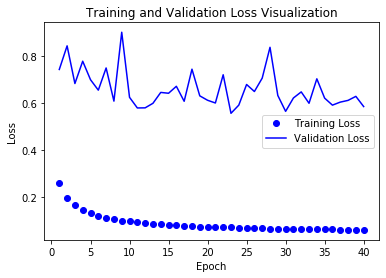

In [81]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epoch = range(1,len(loss)+1)

plt.plot(epoch,loss,'bo',label='Training Loss')
plt.plot(epoch,val_loss,'b',label='Validation Loss')
plt.title('Training and Validation Loss Visualization')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()